# User's guide to accessing PZ outputs directly from the DP1 butler

In [1]:
algo_1 = 'knn'
algo_2 = 'bpz'
flux_model = 'gaap1p0'
use_six_band = True

Imports and butler set up

In [2]:
import numpy as np
from lsst.daf.butler import Butler
from astropy.table import Table, join
from astropy import units as u
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
butler = Butler('/repo/dp1')

In [4]:
pz_collection = 'LSSTComCam/runs/DRP/DP1/pz/DM-51523/gold/dp1_6band/v1'

In [5]:
butler.registry.queryCollections('LSSTComCam/runs/DRP/DP1/pz/*')

['LSSTComCam/runs/DRP/DP1/pz/DM-51523/gold/baseline/v1/20250626T031837Z',
 'LSSTComCam/runs/DRP/DP1/pz/DM-51523/gold/dp1_6band/v1/20250626T040434Z',
 'LSSTComCam/runs/DRP/DP1/pz/DM-51523/gold/dp1_6band/v1/20250626T172245Z',
 'LSSTComCam/runs/DRP/DP1/pz/DM-51523/gold/baseline/v1',
 'LSSTComCam/runs/DRP/DP1/pz/DM-51523/gold/dp1_6band/v1']

Available algorithms

In [55]:
butler.registry.queryDatasetTypes('pz_estimate_*')

[DatasetType('pz_estimate_bpz', {skymap, tract}, QPEnsemble),
 DatasetType('pz_estimate_cmnn', {skymap, tract}, QPEnsemble),
 DatasetType('pz_estimate_dnf', {skymap, tract}, QPEnsemble),
 DatasetType('pz_estimate_fzboost', {skymap, tract}, QPEnsemble),
 DatasetType('pz_estimate_gpz', {skymap, tract}, QPEnsemble),
 DatasetType('pz_estimate_knn', {skymap, tract}, QPEnsemble),
 DatasetType('pz_estimate_tpz', {skymap, tract}, QPEnsemble),
 DatasetType('pz_estimate_lephare', {skymap, tract}, QPEnsemble)]

Pull data from butler

In [7]:
ens_algo_1 = butler.get(f'pz_estimate_{algo_1}', instrument='LSSTComCam', skymap='lsst_cells_v1', tract=5063, collections=pz_collection)

In [8]:
ens_algo_2 = butler.get(f'pz_estimate_{algo_2}', instrument='LSSTComCam', skymap='lsst_cells_v1', tract=5063, collections=pz_collection)

In [9]:
algo_1_table  = Table(ens_algo_1.ancil)

In [10]:
algo_2_table  = Table(ens_algo_2.ancil)

In [56]:
obj_columns = ['objectId', 'coord_ra', 'coord_dec', 
               'g_extendedness', 'r_extendedness',
               f'u_{flux_model}Flux', f'g_{flux_model}Flux', 
               f'r_{flux_model}Flux', f'i_{flux_model}Flux', 
               f'z_{flux_model}Flux', f'y_{flux_model}Flux',
               f'u_{flux_model}FluxErr', f'g_{flux_model}FluxErr', 
               f'r_{flux_model}FluxErr', f'i_{flux_model}FluxErr', 
               f'z_{flux_model}FluxErr', f'y_{flux_model}FluxErr']
if flux_model != 'psf':
    obj_columns.append('i_psfFlux')
    obj_columns.append('i_psfFluxErr')

In [57]:
obj_table = butler.get('object', 
                       instrument='LSSTComCam', 
                       skymap='lsst_cells_v1', 
                       tract=5063, 
                       collections=pz_collection, 
                       parameters={'columns': obj_columns})

Object Table Cuts

In [58]:
obj_table = obj_table[(obj_table['g_extendedness'].mask > 0.5) | (obj_table['r_extendedness'].mask > 0.5)]

In [59]:
obj_table = obj_table[(obj_table['i_psfFlux'] / obj_table['i_psfFluxErr']) > 5.]

Join Tables

In [14]:
pz_table = join(algo_1_table, algo_2_table, keys='id', table_names=[algo_1, algo_2])

In [39]:
combined_table = join(pz_table, obj_table, keys_left='id', keys_right='objectId')

Calculate magnitudes and select six or four band objects

In [40]:
six_band = [True] * len(combined_table)
four_band = [True] * len(combined_table)
band_list = ['u', 'g', 'r', 'i', 'z', 'y']
for band_label in band_list:
    combined_table[f'{band_label}_{flux_model}Mag'] = \
        (combined_table[f'{band_label}_{flux_model}Flux']*u.nJy).to(u.ABmag)
    six_band *= ~np.isnan(combined_table[f'{band_label}_{flux_model}Mag'])
    if band_label in band_list[1:5]:
        four_band *= ~np.isnan(combined_table[f'{band_label}_{flux_model}Mag'])

In [41]:
if use_six_band is True:
    combined_table = combined_table[np.where(six_band == True)]
    print(f'Total number of objects with all six bands: {len(combined_table)}')
else:
    combined_table = combined_table[np.where(four_band == True)]
    print(f'Total number of objects with four bands (griz): {len(combined_table)}')

Total number of objects with all six bands: 56073


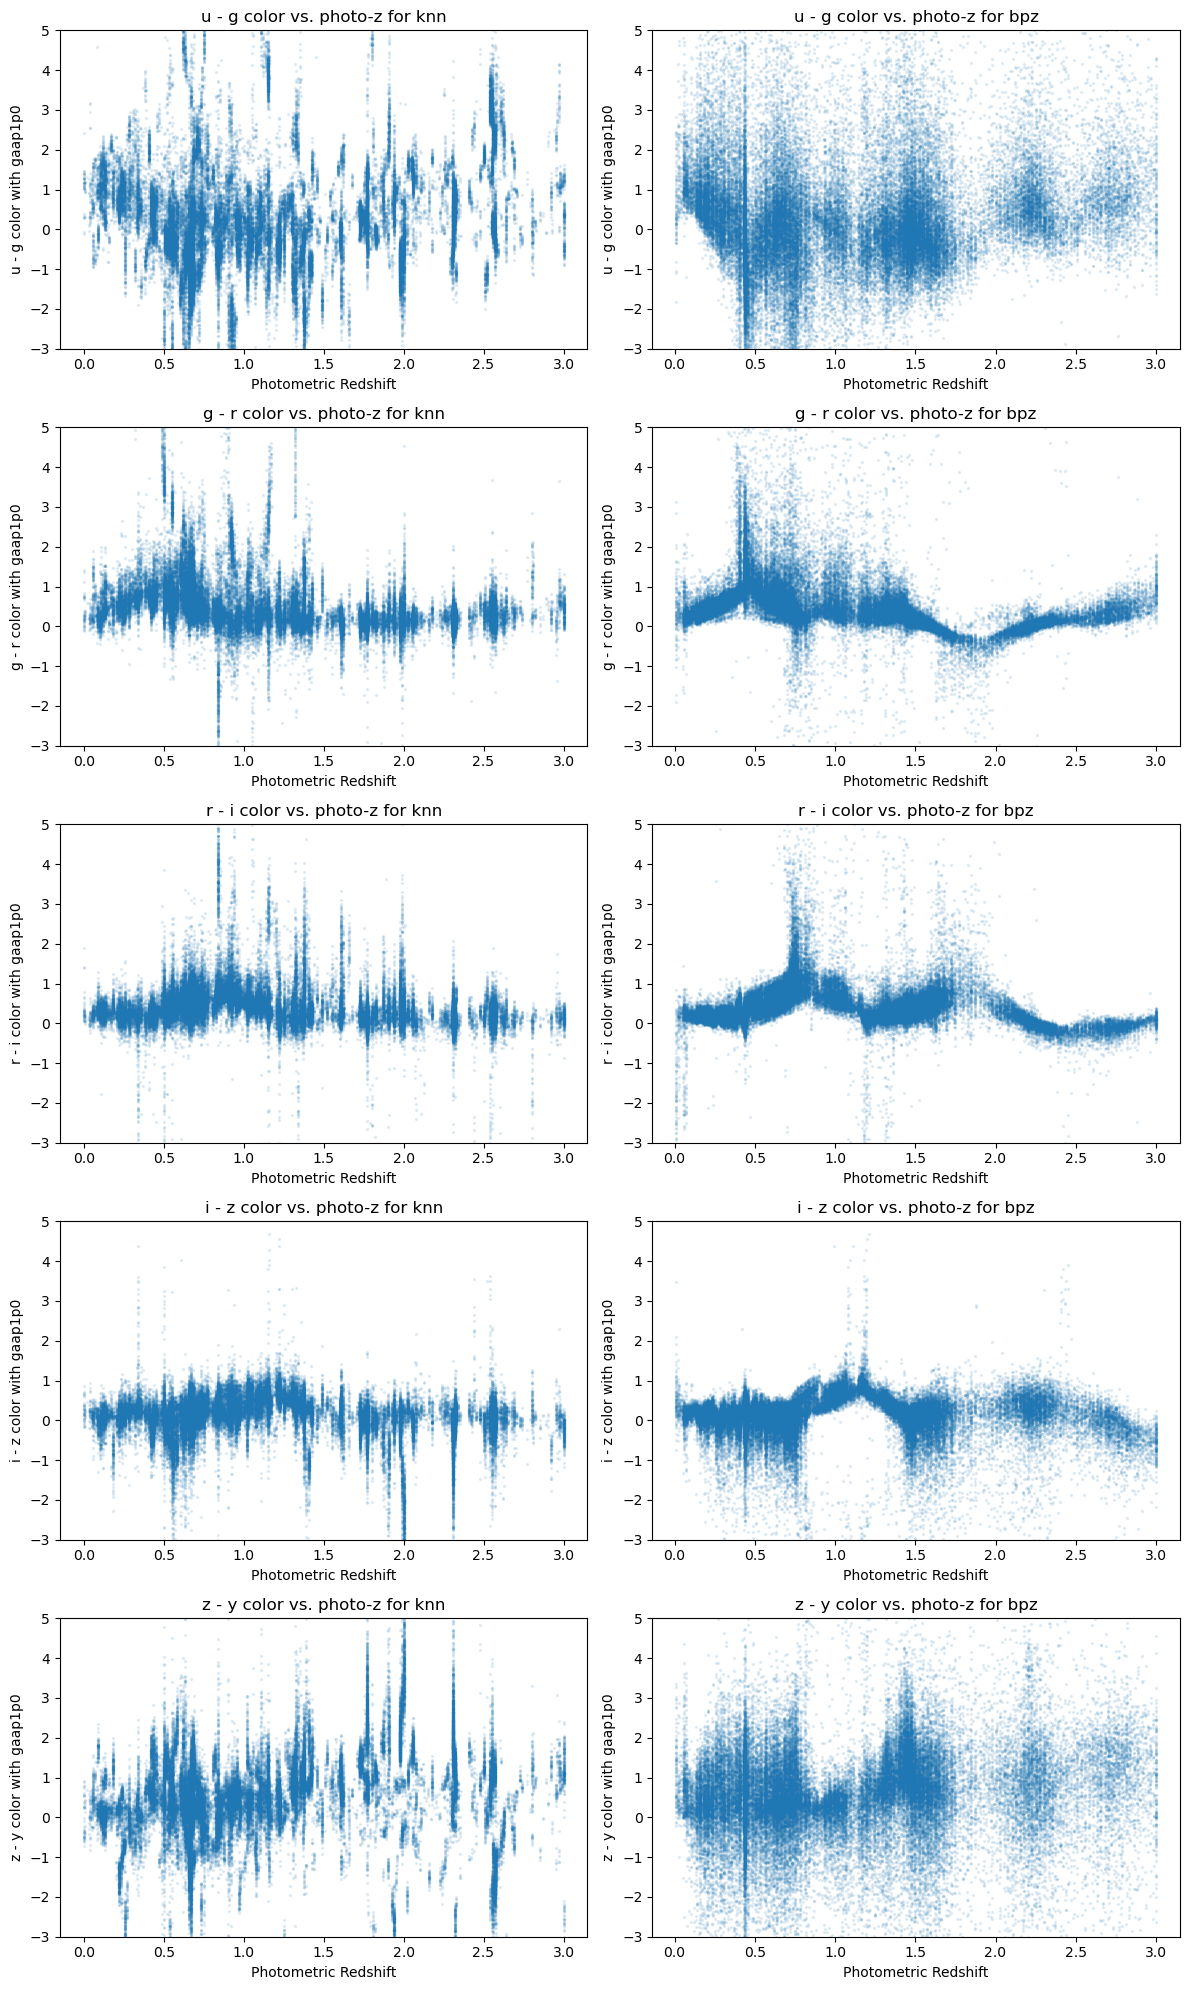

In [51]:
fig = plt.figure(figsize=(12, 20))
plot_idx = 1
for band_1, band_2 in zip(band_list[:-1], band_list[1:]):
    color_on = combined_table[f'{band_1}_{flux_model}Mag'] - combined_table[f'{band_2}_{flux_model}Mag']
    
    fig.add_subplot(5, 2, plot_idx) 
    plt.scatter(combined_table[f'z_mode_{algo_1}'], color_on, s=2, alpha=0.1)
    plt.title(f'{band_1} - {band_2} color vs. photo-z for {algo_1}')
    plt.ylim(-3, 5)
    plt.xlabel('Photometric Redshift')
    plt.ylabel(f'{band_1} - {band_2} color with {flux_model}')
    
    plot_idx += 1

    fig.add_subplot(5, 2, plot_idx) 
    plt.scatter(combined_table[f'z_mode_{algo_2}'], color_on, s=2, alpha=0.1)
    plt.title(f'{band_1} - {band_2} color vs. photo-z for {algo_2}')
    plt.ylim(-3, 5)
    plot_idx += 1
    plt.xlabel('Photometric Redshift')
    plt.ylabel(f'{band_1} - {band_2} color with {flux_model}')
plt.tight_layout()

Text(0, 0.5, 'Count')

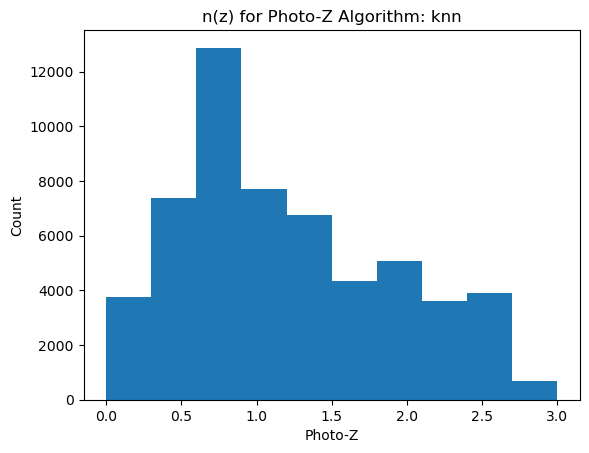

In [52]:
plt.hist(combined_table[f'z_mode_{algo_1}'])
plt.title(f'n(z) for Photo-Z Algorithm: {algo_1}')
plt.xlabel('Photo-Z')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

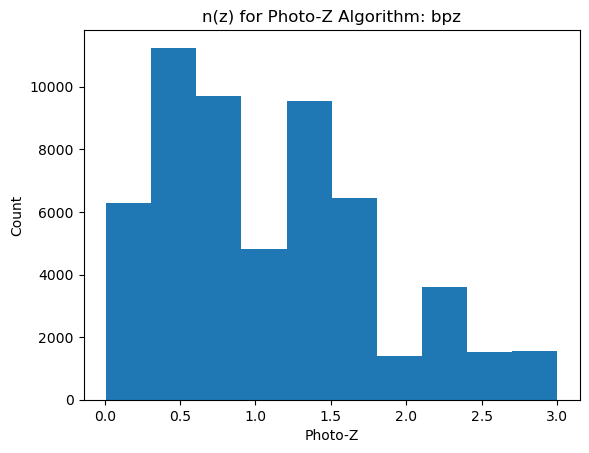

In [53]:
plt.hist(combined_table[f'z_mode_{algo_2}'])
plt.title(f'n(z) for Photo-Z Algorithm: {algo_2}')
plt.xlabel('Photo-Z')
plt.ylabel('Count')

Text(0.5, 1.0, 'Comparing n(z) for two algorithms')

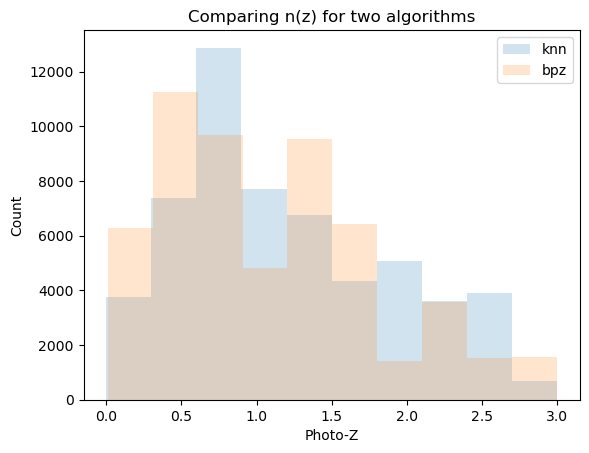

In [54]:
plt.hist(combined_table[f'z_mode_{algo_1}'], alpha=0.2, label=algo_1)
plt.hist(combined_table[f'z_mode_{algo_2}'], alpha=0.2, label=algo_2)
plt.legend()
plt.xlabel('Photo-Z')
plt.ylabel('Count')
plt.title('Comparing n(z) for two algorithms')